# How to create subgraphs

For more complex systems, subgraphs are a useful design principle. Subgraphs allow you to create and manage different states in different parts of your graph. This allows you build things like [multi-agent teams](https://langchain-ai.github.io/langgraphjs/tutorials/multi_agent/hierarchical_agent_teams/), where each team can track its own separate state.

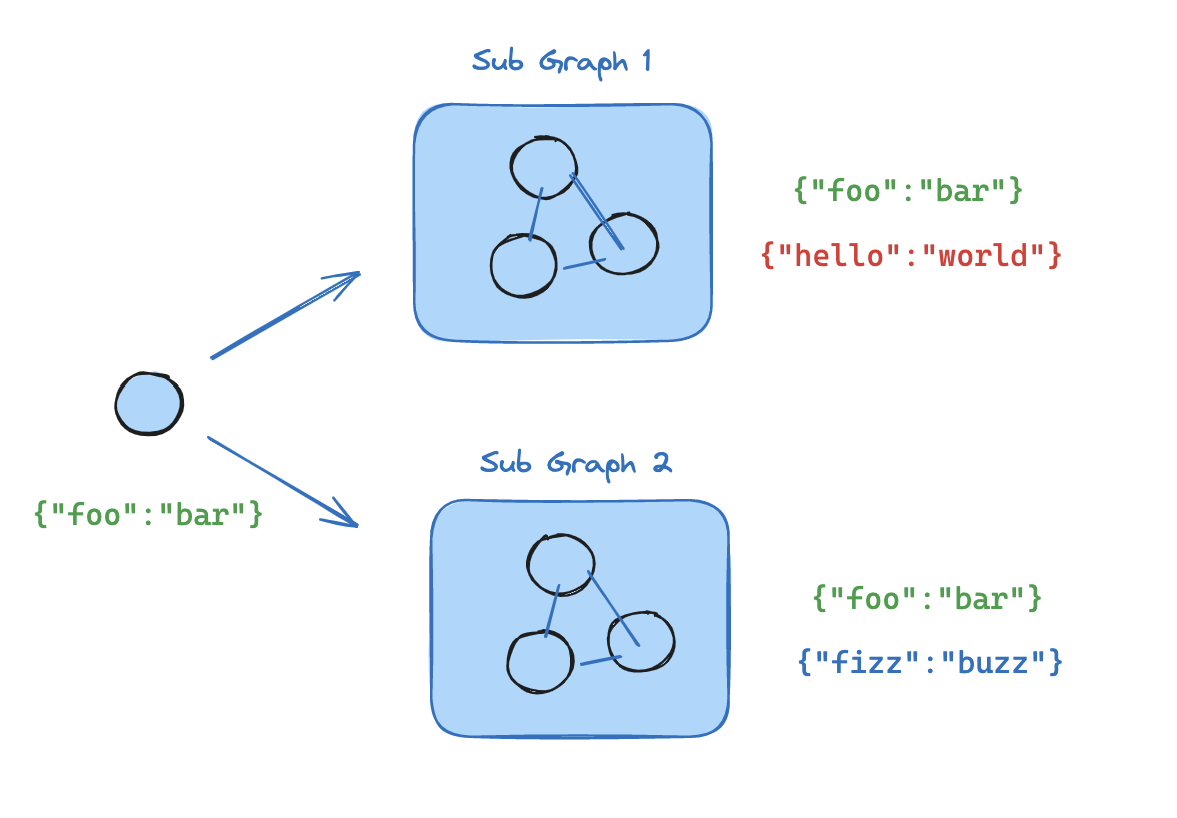

## Setup

First, let's install the required packages

```bash
npm install @langchain/langgraph @langchain/core
```

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Simple example

Let's consider a toy example: a system that accepts logs from another system as input and perform two separate sub-tasks. First, it will summarize them. Second, it will summarize any failure modes captured in the logs. These two operations will be performed by two different subgraphs.

The most important thing to recognize is the information transfer between the graphs. `Entry Graph` is the parent, and each of the two subgraphs are defined as nodes in `Entry Graph`. Both subgraphs inherit state from the parent `Entry Graph`; I can access `docs` in each of the subgraphs simply by specifying it in the subgraph state (see diagram). Each subgraph can have its own private state. And any values that I want propagated back to the parent `Entry Graph` (for final reporting) simply need to be defined in my `Entry Graph` state (e.g., `summary report` and `failure report`).

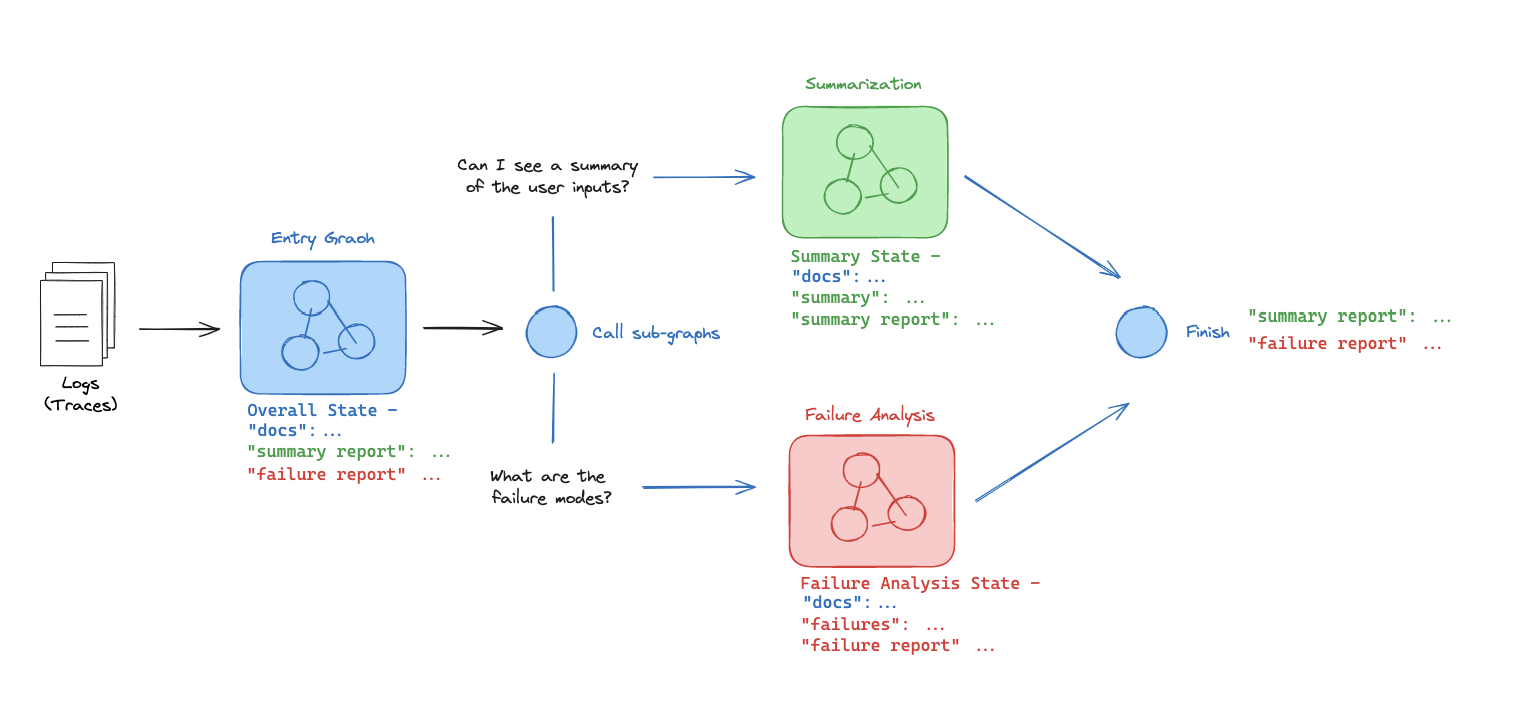

### Define subgraphs

To start, we'll define the failure analysis and summarization subgraphs from the diagram above:

In [1]:
import { StateGraph, START, Annotation } from "@langchain/langgraph";

// Custom structure for adding logs from subgraphs to the state
interface Log {
  type: string;
  id: string
  question: string
  answer: string
  grade?: number
  feedback?: string
}

// Define custom reducer (see more on this in the "Custom reducer" section below)
const addLogs = (left: Log[], right: Log[]): Log[] => {
  let newLeft = left || [];
  let newRight = right || [];

  const logs = [...newLeft];
  const leftIdToIdx = new Map(logs.map((log, idx) => [log.id, idx]));

  // update if the new logs are already in the state, otherwise append
  for (const log of newRight) {
    const idx = leftIdToIdx.get(log.id);
    if (idx !== undefined) {
      logs[idx] = log;
    } else {
      logs.push(log);
    }
  }

  return logs;
};

// Failure Analysis Subgraph
const FailureAnalysisAnnotation = Annotation.Root({
  // keys shared with the parent graph (EntryGraphState)
  logs: Annotation<Log[]>({
    reducer: addLogs,
    default: () => [],
  }),
  failureReport: Annotation<string>,
  // subgraph key
  failures: Annotation<Log[]>,
})

const getFailures = (state: typeof FailureAnalysisAnnotation.State) => {
  const failures = state.logs.filter(log => log.grade === 0);
  return { failures };
}

const generateSummary = (state: typeof FailureAnalysisAnnotation.State) => {
  const failureIds = state.failures.map(log => log.id);
  // NOTE: you can implement custom summarization logic here
  const failureReport = `Poor quality of retrieval for document IDs: ${failureIds.join(", ")}`;
  return { failureReport };
}


const failureBuilder = new StateGraph(FailureAnalysisAnnotation)
  .addNode("getFailures", getFailures)
  .addNode("generateSummary", generateSummary)
  .addEdge(START, "getFailures")
  .addEdge("getFailures", "generateSummary");

// Summarization subgraph
const QuestionSummarizationAnnotation = Annotation.Root({
  // keys that are shared with the parent graph (EntryGraphState)
  summaryReport: Annotation<string>,
  logs: Annotation<Log[]>({
    reducer: addLogs,
    default: () => [],
  }),
  // subgraph key
  summary: Annotation<string>,
})

const generateQuestionSummary = (_state: typeof QuestionSummarizationAnnotation.State) => {
  // NOTE: you can implement custom summarization logic here
  const summary = "Questions focused on usage of ChatOllama and Chroma vector store.";
  return { summary };
}

const sendToSlack = (state: typeof QuestionSummarizationAnnotation.State) => {
  const summary = state.summary;
  // NOTE: you can implement custom logic here, for example sending the summary generated in the previous step to Slack
  return { summaryReport: summary };
}

const questionSummarizationBuilder = new StateGraph(QuestionSummarizationAnnotation)
  .addNode("generateQuestionSummary", generateQuestionSummary)
  .addNode("sendToSlack", sendToSlack)
  .addEdge(START, "generateQuestionSummary")
  .addEdge("generateQuestionSummary", "sendToSlack");

Note that each subgraph has its own state, `QuestionSummarizationAnnotation` and `FailureAnalysisAnnotation`.
 
After defining each subgraph, we put everything together.

### Define parent graph

In [2]:
// Dummy logs
const dummyLogs: Log[] = [
  {
    type: "log",
    id: "1",
    question: "How can I import ChatOllama?",
    grade: 1,
    answer: `To import ChatOllama, use: 'import { ChatOllama } from "@langchain/ollama";'`,
  },
  {
    type: "log",
    id: "2",
    question: "How can I use Chroma vector store?",
    answer: `To use Chroma, define: "const ragChain = await createRetrievalChain(retriever, questionAnswerChain);".`,
    grade: 0,
    feedback: "The retrieved documents discuss vector stores in general, but not Chroma specifically",
  },
  {
    type: "log",
    id: "3",
    question: "How do I create a react agent in langgraph?",
    answer: `import { createReactAgent } from "@langchain/langgraph";`,
  }
];


// Entry Graph
const EntryGraphAnnotation = Annotation.Root({
  rawLogs: Annotation<Log[]>({
    reducer: addLogs,
    default: () => [],
  }),
  // This will be used in subgraphs
  logs: Annotation<Log[]>({
    reducer: addLogs,
    default: () => [],
  }),
  // This will be generated in the failure analysis subgraph
  failureReport: Annotation<string>,
  // This will be generated in the summarization subgraph
  summaryReport: Annotation<string>,
});

const selectLogs = (state: typeof EntryGraphAnnotation.State) => {
  return { logs: state.rawLogs.filter((log) => "grade" in log) };
}

const entryBuilder = new StateGraph(EntryGraphAnnotation)
  .addNode("selectLogs", selectLogs)
  .addNode("questionSummarization", questionSummarizationBuilder.compile())
  .addNode("failureAnalysis", failureBuilder.compile())
  // Add edges
  .addEdge(START, "selectLogs")
  .addEdge("selectLogs", "failureAnalysis")
  .addEdge("selectLogs", "questionSummarization");

const graph = entryBuilder.compile()

In [3]:
const result = await graph.invoke({ rawLogs: dummyLogs });
console.dir(result, { depth: null });

{
  rawLogs: [
    {
      type: 'log',
      id: '1',
      question: 'How can I import ChatOllama?',
      grade: 1,
      answer: `To import ChatOllama, use: 'import { ChatOllama } from "@langchain/ollama";'`
    },
    {
      type: 'log',
      id: '2',
      question: 'How can I use Chroma vector store?',
      answer: 'To use Chroma, define: "const ragChain = await createRetrievalChain(retriever, questionAnswerChain);".',
      grade: 0,
      feedback: 'The retrieved documents discuss vector stores in general, but not Chroma specifically'
    },
    {
      type: 'log',
      id: '3',
      question: 'How do I create a react agent in langgraph?',
      answer: 'import { createReactAgent } from "@langchain/langgraph";'
    }
  ],
  logs: [
    {
      type: 'log',
      id: '1',
      question: 'How can I import ChatOllama?',
      grade: 1,
      answer: `To import ChatOllama, use: 'import { ChatOllama } from "@langchain/ollama";'`
    },
    {
      type: 'log',
      id: '2',

## Custom reducer functions to manage state

You might have noticed that we defined a custom [reducer](https://langchain-ai.github.io/langgraphjs/concepts/low_level/#reducers) function (`addLogs`) or the `logs` key in `EntryGraphAnnotation`. It is necessary to provide a reducer when using shared state keys across multiple subgraphs.

Let's take a closer look at the steps involved in implementing a reducer. We will create two graphs: a parent graph with a few nodes and a child graph that is added as a node in the parent. We'll also define a custom reducer function (`reduceList`) for our state. The first iteration of this will simply concatenate the current state value and the updated one together:

In [4]:
import { StateGraph, START, Annotation } from "@langchain/langgraph";

// Define a simple reducer
const reduceList = (left: any[], right?: any[]): any[] => {
  const newLeft = left || [];
  const newRight = right || [];
  return [...newLeft, ...newRight];
};

// Define parent and child state
const ChildStateAnnotation = Annotation.Root({
  name: Annotation<string>,
  path: Annotation<any[]>({ reducer: reduceList, default: () => [] }),
});

const ParentStateAnnotation = Annotation.Root({
  name: Annotation<string>,
  path: Annotation<any[]>({ reducer: reduceList, default: () => [] }),
});

// Define a helper to build the graph
const makeGraph = (parentSchema: any, childSchema: any) => {
  const childBuilder = new StateGraph(childSchema)
    .addNode("childStart", (_) => ({ path: ["childStart"] }))
    .addEdge(START, "childStart")
    .addNode("childMiddle", (_) => ({ path: ["childMiddle"] }))
    .addNode("childEnd", (_) => ({ path: ["childEnd"] }))
    .addEdge("childStart", "childMiddle")
    .addEdge("childMiddle", "childEnd");

  const builder = new StateGraph(parentSchema)
    .addNode("grandparent", (_) => ({ path: ["grandparent"] }))
    .addEdge(START, "grandparent")
    .addNode("parent", (_) => ({ path: ["parent"] }))
    .addNode("child", childBuilder.compile())
    .addNode("sibling", (_) => ({ path: ["sibling"] }))
    .addNode("fin", (_) => ({ path: ["fin"] }))
    // Add nodes
    .addEdge("grandparent", "parent")
    .addEdge("parent", "child")
    .addEdge("parent", "sibling")
    .addEdge("child", "fin")
    .addEdge("sibling", "fin");

  return builder.compile();
};

// Create the graph
const graphWithReducer = makeGraph(ParentStateAnnotation, ChildStateAnnotation);

In [5]:
const result2 = await graphWithReducer.invoke({ name: "test" });
console.dir(result2, { depth: null });

{
  name: 'test',
  path: [
    'grandparent',
    'parent',
    'grandparent',
    'parent',
    'childStart',
    'childMiddle',
    'childEnd',
    'sibling',
    'fin'
  ]
}


Notice here that the `["grandparent", "parent"]` sequence is duplicated! 

This is because our child state has received the full parent state and returns the full parent state once it terminates. 

To avoid duplication or conflicts in state, you typically would do one or more of the following:

1. Handle duplicates in your `reducer` function.
2. Call the child graph from within a function. In that function, handle the state as needed.  
3. Update the child graph keys to avoid conflicts. You would still need to ensure the output can be interpreted by the parent, however.

Let's re-implement the graph using technique (1) and add unique IDs for every value in the list. This is what is done in [`MessagesAnnotation`](https://langchain-ai.github.io/langgraphjs/reference/variables/langgraph.MessagesAnnotation.html).

In [6]:
import { v4 as uuidv4 } from 'uuid';

const reduceList2 = (left: any[], right?: any[]): any[] => {
  const newLeft = left || [];
  const newRight = right || [];
  const left_ = [];
  const right_ = [];
  for (const [orig, new_] of [[newLeft, left_], [newRight, right_]]) {
    for (let val of orig) {
      if (typeof val !== "object") {
        val = { val };
      }
      if (typeof val === "object" && !("id" in val)) {
        val.id = uuidv4();
      }
      new_.push(val);
    }
  }
  // Merge the two lists
  const leftIdxById = new Map(left_.map((val, i) => [val.id, i]));
  const merged = [...left_];
  for (const val of right_) {
    if (leftIdxById.has(val.id)) {
      merged[leftIdxById.get(val.id)] = val;
    } else {
      merged.push(val);
    }
  }
  return merged;
}

const ChildAnnotation = Annotation.Root({
  name: Annotation<string>,
  // note the updated reducer here
  path: Annotation<any[]>({ reducer: reduceList2, default: () => [] }),
})

const ParentAnnotation = Annotation.Root({
  name: Annotation<string>,
  // note the updated reducer here
  path: Annotation<any[]>({ reducer: reduceList2, default: () => [] }),
})


Since our graph topology hasn't changed, we can just reuse the same `makeGraph` helper function we defined previously and pass new schema for the parent and child graphs.

In [7]:
const graphWithNewReducer = makeGraph(ParentAnnotation, ChildAnnotation)
const result3 = await graphWithNewReducer.invoke({ name: "test" });
console.dir(result3, { depth: null });

{
  name: 'test',
  path: [
    { val: 'grandparent', id: 'be824684-5107-41c2-b78e-71ef9878289b' },
    { val: 'parent', id: '1d6a392e-d350-4bef-a8a5-d36e07308cb7' },
    { val: 'childStart', id: '367a76a2-bae9-41c7-8a82-26f42cd393b3' },
    { val: 'childMiddle', id: '9052bffa-1d18-491a-b78b-d1763cafb42a' },
    { val: 'childEnd', id: '1299922c-5b0a-42bb-bc30-70afd3111d4a' },
    { val: 'sibling', id: '5eef5e4c-fac3-4d60-a486-a115d32410cf' },
    { val: 'fin', id: '2f8244b1-7cdc-41e8-8dd4-ef390deb8323' }
  ]
}


You can see that that now the path values are no longer duplicated thanks to the updated reducer we introduced above.